In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Slå ihop till ett gemensamt dataset


def gender(val):
    if 'dam' in val or 'Dam' in val or 'kvinna' in val or 'kvinna' in val:
        return 'F'
    else: return 'M'
    
def fill_gender(df):
    df_temp = pd.DataFrame()
    for name in df['namn'].unique():
        df_t = df[df['namn'] == name]
        if 'F' in df_t['kön'].unique():
            df_t['kön'] = 'F'
        else: 
            df_t['kön'] = 'M'
        df_temp = pd.concat([df_temp, df_t])
    return df_temp

df = pd.read_csv('complete_total.csv')
df = df[['tävling','datum','typ','vikt','böj','bänk','mark','total','poäng','namn','förening','distrikt']]
df['kön'] = df.apply(lambda x: gender(x['tävling']), axis=1)
df['år'] = df['datum'].apply(lambda x: str(x).split('-')[0])
df = fill_gender(df)

def get_male_weightclass(val):
    if float(val) < 66:
        return 66
    elif float(val) < 74:
        return 74
    elif float(val) < 83:
        return 83
    elif float(val) < 93:
        return 93
    elif float(val) < 105:
        return 105
    elif float(val) < 120:
        return 120
    else: return 121
    
def get_female_weightclass(val):
    val = float(val)
    if val < 47:
        return 47
    elif val < 52:
        return 52
    elif val < 57:
        return 57
    elif val < 63:
        return 63
    elif val < 69:
        return 69
    elif val < 76:
        return 76
    elif val < 84:
        return 84
    else: return 85

def is_elite(val):
    if 'NM' in val:
        return True
    if 'VM' in val:
        return True
    if 'EM' in val:
        return True
    if 'SM' in val:
        return True
    if 'Arnold' in val:
        return True
    return False
    
df['vikt'] = df['vikt'].apply(lambda x: float(str(x).replace(',','.')))
df['total'] = df['total'].apply(lambda x: float(str(x).replace(',','.')))
df['poäng'] = df['poäng'].apply(lambda x: float(str(x).replace(',','.')))
df['böj'] = df['böj'].apply(lambda x: float(str(x).replace(',','.')))
df['bänk'] = df['bänk'].apply(lambda x: float(str(x).replace(',','.')))
df['mark'] = df['mark'].apply(lambda x: float(str(x).replace(',','.')))
df['viktklass'] = df.apply(lambda x: get_male_weightclass(x['vikt']) if x['kön'] == 'M' else get_female_weightclass(x['vikt']), axis=1)
df['total'] = df['total'].astype(float)
df['vikt'] = df['vikt'].astype(float)
df['elit'] = df.apply(lambda x:is_elite(x['tävling']), axis=1)
df

## 2. Analysera datan

In [3]:
df = pd.read_csv('complete_total.csv')

df = df.sort_values(['namn','bänk','typ','vikt'])
df = df.drop_duplicates(subset=['namn','år','bänk','vikt'], keep='last')
df

,tävling,datum,typ,vikt,böj,bänk,mark,total,poäng,namn,förening,distrikt,kön,år,viktklass,elit
7871,Allsvenska SL,2009-05-06,SL,98.08,117.5,85.0,175.0,377.5,231.57,ADAM NORDIN,IFK Dannemora/Österby,Östra Svealands SDF,M,2009.0,105,False
24587,DM i styrkelyft (klassisk) Västra Svealands SDF,2015-11-14,KSL,103.30,235.0,130.0,300.0,665.0,399.71,Abdel Seidouvy,NaN,NaN,M,2015.0,105.00,True
24279,U/J/V SM Styrkelyft (klassiskt),2016-05-04,KSL,101.85,230.0,135.0,290.0,655.0,395.78,Abdel Seidouvy,NaN,NaN,M,2016.0,105.00,True
27074,DM Bänkpress klassisk MNSF,2021-09-18,KBP,60.92,NaN,60.0,NaN,NaN,66.11,Abigail Sandström,NaN,NaN,F,2021.0,63.00,True
22741,DM i Styrkelyft klassisk SSSF,2021-10-16,KSL,77.55,142.5,77.5,180.0,400.0,278.63,Abubaker Mohammed-Abdu,NaN,NaN,M,2021.0,83.00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10890,Enbart ranking herr BP,2019-05-12,BP,146.80,NaN,267.5,NaN,NaN,148.46,Örjan Dahl,Degerfors AK,Västra Svealands SDF,M,2019.0,121,False
10889,Enbart ranking herr BP,2019-09-15,BP,148.10,NaN,272.5,NaN,NaN,151.04,Örjan Dahl,Degerfors AK,Västra Svealands SDF,M,2019.0,121,False
10898,Enbart ranking BP herr,2016-02-06,BP,146.50,NaN,275.0,NaN,NaN,152.66,Örjan Dahl,Degerfors AK,Västra Svealands SDF,M,2016.0,121,False
10897,VM Bänkpress (Rödby) 2016,2016-04-21,BP,148.52,NaN,280.0,NaN,NaN,155.14,Örjan Dahl,Degerfors AK,Västra Svealands SDF,M,2016.0,121,True


-----

## En analys av svenskt styrkelyft
Sverige har en lång historia av duktiga styrkelyftare och bänkpressare, och idag är Sverige en av de ledande nationerna i de båda sporterna. Vi ser en ökat intresse av kraftsporter, vilket till stor del kan attribueras till sociala medier och starka personligheter inom sporterna. Det ökade intresset innebär fler tävlande, och speciellt fler duktiga tävlande. Ett rekord för 20 år sedan är en ingångsvikt på världscenen idag, och vi ser även att kvalitén på lyftare har ökat markant på en nationell nivå. Detta återspeglas särskilt i ökningen av kvalgränser och standard. Gemene man kan även lägga märke till andra tendenser inom sporten - ett skiftande från utrustad till klassisk lyftning, en föryngring av tävlande, och en mer jämnlik sport. Jag har använt mig av Svenska Styrkelyfts Förbundents databas för analysera dessa trender, och se på den svenska utvecklingen i styrkelyft och bänkpress.

In [19]:
df['count'] = 1
antal_unika_tävlande = len(df['namn'].unique())
print('Tävlande: ', antal_unika_tävlande)
antal_tävlingar = len(df['tävling'].unique())
print('Tävlingar: ', antal_tävlingar)
kön = df.groupby('kön').sum()
print(kön['count'])
unika_kön = df.groupby(['namn','kön']).sum()
unika_kön['count'] = 1
unika_kön = unika_kön.groupby('kön').sum()
print(unika_kön['count'])
kategori_df = df.groupby(['typ']).sum()
print(kategori_df['count'])

Tävlande:  4405
Tävlingar:  881
kön
F     6464
M    20261
Name: count, dtype: int64
kön
F    1077
M    3353
Name: count, dtype: int64
typ
BP      5724
KBP     4741
KSL    10022
SL      6238
Name: count, dtype: int64


## Demografi
Totalt analyseras resultaten från 3135 unika tävlande, varav 2292 är herrar och 848 damer. Det finns 10420 datapunkter, varav 7695 herrar och 2725 är damer, från 338 tävlingar mellan 2008/05/06 och 2022/05/05 (14 år). I klassisk styrkelyft/bänkpress finns 3526 respektive 1868 datapunkter. I utrustad styrkelyft/bänkpress finns 2113 respektive 2913 datapunkter. Majoriteten av alla lyftare (1317 st) har enbart utfört 1 tävling, och 613 st har utfört 2 tävlingar. Tomas Ring har utfört flest tävlingar (52 st).

namn
Jonas Telégin        104
Karolina Arvidson     93
Markus Larsson        88
Lars Höglander        85
Åsa  Halvarsson       82
Name: count, dtype: int64
count
1    1241
2     749
3     467
4     377
5     252
Name: count_of_count, dtype: int64
Antal med 1 tävling:  1241


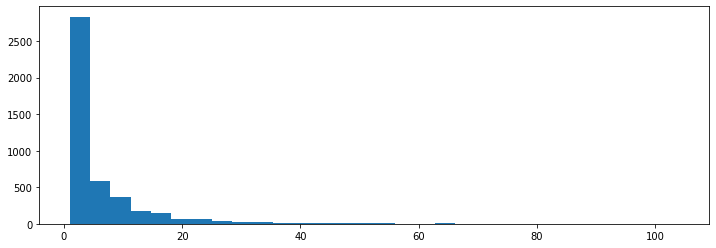

In [20]:
# fördelning av tävlingar per individ
tävlande = df.groupby('namn').sum()
tävlande.sort_values('count', ascending=False, inplace=True)
print(tävlande.head()['count'])
tävlande['count_of_count'] = 1
print(tävlande.groupby('count').sum()['count_of_count'].head())
print('Antal med 1 tävling: ', len(tävlande[tävlande['count'] == 1].index))
fig = plt.figure(figsize=(12,4))
plt.hist(tävlande['count'], bins=30)
plt.show()

Antal tävlande över tid ökade mellan 2009 - 2019 från ~750 till ~1200. Därefter slog pandemin, och antalet tävlande var låga 2020 och 2021 (<500). Antalet tävlande i utrustning går stadigt ner, och efter coronapandemin slog är det färre än 100 tävlande i utrustad styrkelyft. Antalet tävlande damer såg en särskild utveckling över tid, både inom klassisk styrkelyft och klassisk bänkpress. 2015 ser vi en stor ökning av lyftare hos både herrar och damer i klassisk styrkelyft, då antalet tävlande nästan dubblerades.

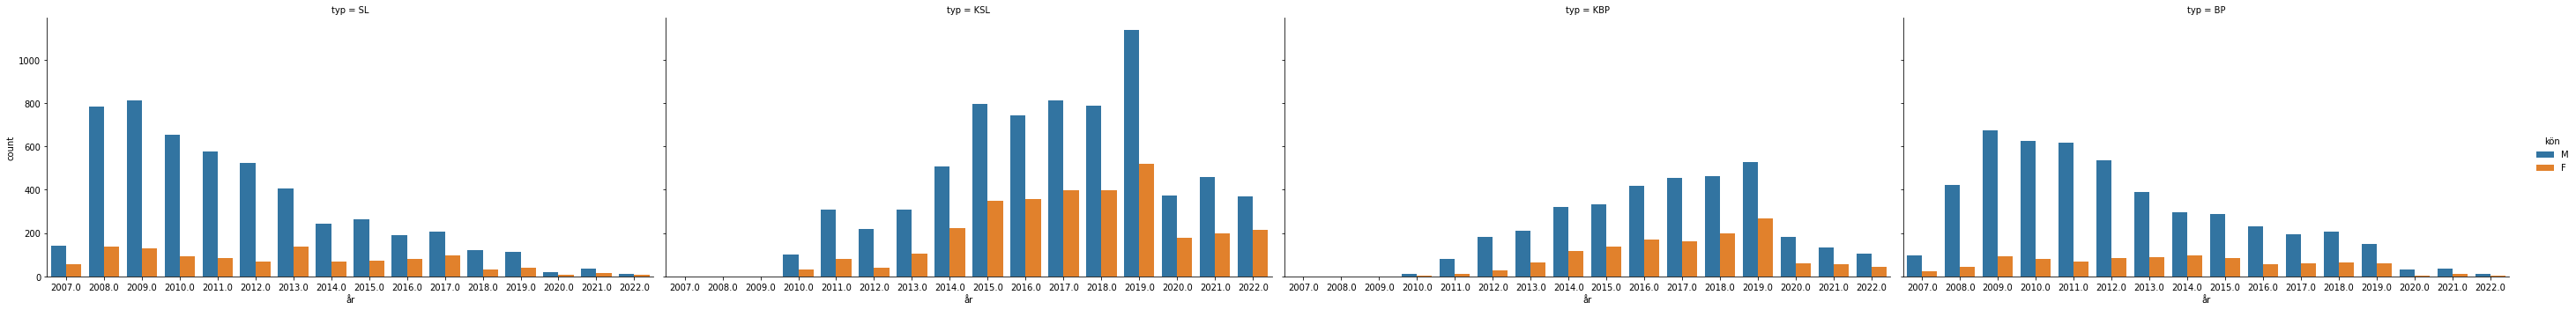

In [21]:


g = sns.catplot(x="år", hue="kön", kind='count',aspect=2,
            col='typ', data=df)


Utrustad lyftning har i alla ålderskategorier varit på en stadig nedgång sedan 2013. Det fanns fler utrustade lyftarna hos herrarna än hos damerna. Både herrar och damer ser en stadig ökning i klassiska lyftare, fram tills pandemin. 

Viktklasserna fördelas olika beroende på ålderskategori.

## Lyftarresultat
Hos både män och kvinnor ser vi en ökning i bästa resultat. Ett undantag skulle vara herrarnas utrustade lyftning, där resultatsutvecklingen varierar. Damerna gör stora framsteg, både inom klassisk och utrustad lyftning.

Om vi bara undersöker klassisk lyftning, så ser vi även en tydlig utveckling hos herrar - speciellt veteraner och juniorer. 

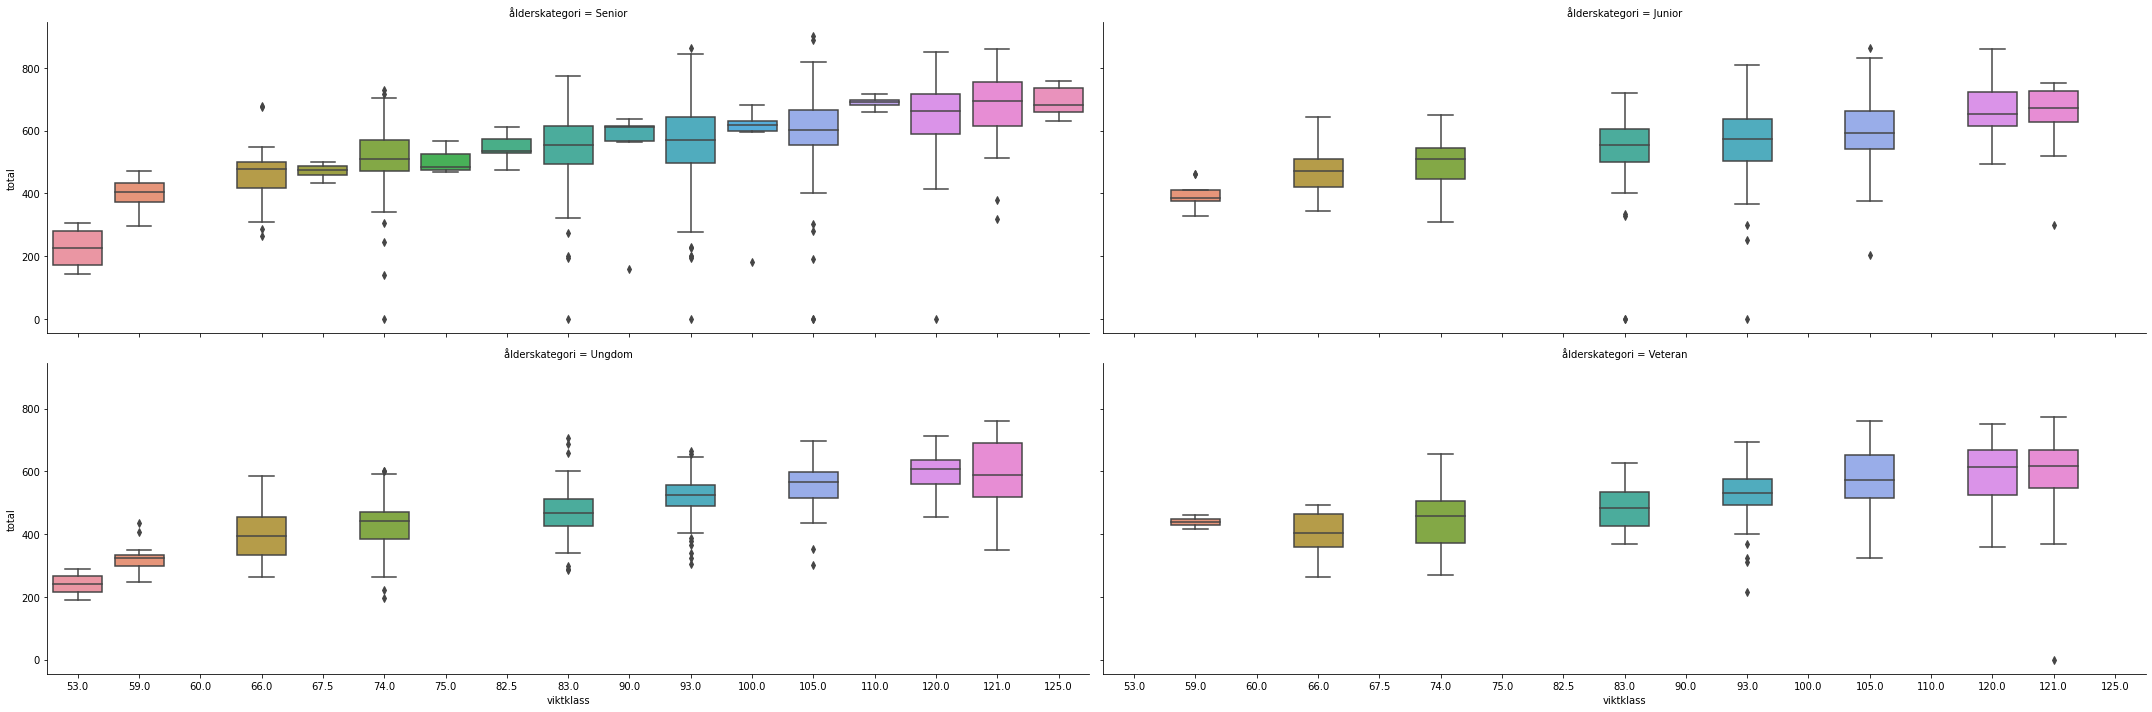

In [116]:
kl = df[df['klassisk/utrustad'] == 'klassisk']
herr = kl[kl['kön'] == 'Herr']

g = sns.catplot(x="viktklass", y="total", col = 'ålderskategori', col_wrap=2, aspect=3,
               data=herr, kind="box")

## Analysera all data - alltså från "Tävlande" istället för tävlingar

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def gender(val):
    if 'dam' in val or 'Dam' in val or 'kvinna' in val or 'kvinna' in val:
        return 'F'
    else: return 'M'
    
def fill_gender(df):
    df_temp = pd.DataFrame()
    for name in df['namn'].unique():
        df_t = df[df['namn'] == name]
        if 'F' in df_t['kön'].unique():
            df_t['kön'] = 'F'
        else: 
            df_t['kön'] = 'M'
        df_temp = pd.concat([df_temp, df_t])
    return df_temp

df = pd.read_csv('complete_v2.csv')
df = df[['tävling','datum','typ','vikt','böj','bänk','mark','total','poäng','namn','förening','distrikt']]
df['kön'] = df.apply(lambda x: gender(x['tävling']), axis=1)
df['år'] = df['datum'].apply(lambda x: str(x).split('-')[0])
df = fill_gender(df)

def get_male_weightclass(val):
    if float(val) < 66:
        return 66
    elif float(val) < 74:
        return 74
    elif float(val) < 83:
        return 83
    elif float(val) < 93:
        return 93
    elif float(val) < 105:
        return 105
    elif float(val) < 120:
        return 120
    else: return 121
    
def get_female_weightclass(val):
    val = float(val)
    if val < 47:
        return 47
    elif val < 52:
        return 52
    elif val < 57:
        return 57
    elif val < 63:
        return 63
    elif val < 69:
        return 69
    elif val < 76:
        return 76
    elif val < 84:
        return 84
    else: return 85

def is_elite(val):
    if 'NM' in val:
        return True
    if 'VM' in val:
        return True
    if 'EM' in val:
        return True
    if 'SM' in val:
        return True
    if 'Arnold' in val:
        return True
    return False
    
df['vikt'] = df['vikt'].apply(lambda x: float(str(x).replace(',','.')))
df['total'] = df['total'].apply(lambda x: float(str(x).replace(',','.')))
df['poäng'] = df['poäng'].apply(lambda x: float(str(x).replace(',','.')))
df['böj'] = df['böj'].apply(lambda x: float(str(x).replace(',','.')))
df['bänk'] = df['bänk'].apply(lambda x: float(str(x).replace(',','.')))
df['mark'] = df['mark'].apply(lambda x: float(str(x).replace(',','.')))
df['viktklass'] = df.apply(lambda x: get_male_weightclass(x['vikt']) if x['kön'] == 'M' else get_female_weightclass(x['vikt']), axis=1)
df['total'] = df['total'].astype(float)
df['vikt'] = df['vikt'].astype(float)
df['elit'] = df.apply(lambda x:is_elite(x['tävling']), axis=1)
df

/home/erikh/training/my-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/erikh/training/my-venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,tävling,datum,typ,vikt,böj,bänk,mark,total,poäng,namn,förening,distrikt,kön,år,viktklass,elit
0,Elitserien dam KL BP,2018-11-19,KBP,62.70,0.0,100.0,0.0,100.0,107.79,Karolina Arvidson,Örebro KK,Västra Svealands SDF,F,2018,63,False
1,"EM Bänkpress, utrustning",2018-10-12,BP,56.89,NaN,122.5,NaN,NaN,142.36,Karolina Arvidson,Örebro KK,Västra Svealands SDF,F,2018,57,True
2,EM klassisk bänkpress 2018,2018-08-11,KBP,56.91,0.0,107.5,0.0,107.5,124.90,Karolina Arvidson,Örebro KK,Västra Svealands SDF,F,2018,57,True
3,SM i Klassisk Bänkpress 2018,2018-07-08,KBP,56.85,0.0,100.0,0.0,100.0,116.28,Karolina Arvidson,Örebro KK,Västra Svealands SDF,F,2018,57,True
4,Enbart Ranking KL BP dam,2018-05-19,KBP,56.14,0.0,105.0,0.0,105.0,123.30,Karolina Arvidson,Örebro KK,Västra Svealands SDF,F,2018,57,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22493,Div 2 Dam SL klassisk,2022-05-14,KSL,56.95,97.5,52.5,100.0,250.0,290.30,Linda Bengtsson,Göteborgs KK,Västra Götaland SDF,F,2022,57,False
22494,Allsvenskan Dam SL klassisk,2022-05-14,KSL,66.10,100.0,62.5,130.0,292.5,303.10,My Haag,Linköpings AK,Sydöstra SDF,F,2022,69,False
22495,Allsvenskan Dam BP klassisk,2022-05-14,KBP,106.20,0.0,80.0,0.0,80.0,65.56,Justyna Kaletka,Täby AK,Östra Svealands SDF,F,2022,85,False
22496,Div 1 Herr BP klassisk,2022-05-18,KBP,84.05,0.0,110.0,0.0,110.0,72.89,Richard Landt,Håbo AK,Östra Svealands SDF,M,2022,93,False


namn
Jonas Telégin        120
Karolina Arvidson    114
Markus Larsson       101
Åsa  Halvarsson       94
Lars Höglander        91
Name: count, dtype: int64
count
1    1190
2     695
3     461
4     351
5     264
Name: count_of_count, dtype: int64
Antal med 1 tävling:  1190


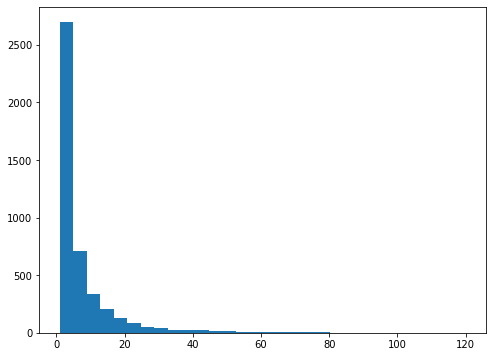

In [43]:

df['count'] = 1
tävlande = df.groupby('namn').sum()
tävlande.sort_values('count', ascending=False, inplace=True)
print(tävlande.head()['count'])
tävlande['count_of_count'] = 1
print(tävlande.groupby('count').sum()['count_of_count'].head())
print('Antal med 1 tävling: ', len(tävlande[tävlande['count'] == 1].index))
fig = plt.figure(figsize=(8,6))
plt.hist(tävlande['count'], bins=30)
plt.show()

/home/erikh/training/my-venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<Figure size 432x288 with 0 Axes>

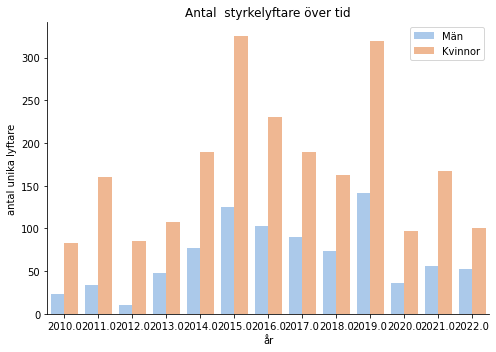

In [23]:

df['år'].replace('nan',np.nan, inplace=True)
df = df.dropna(subset=['år'])
plt.clf()
df.sort_values('år', inplace=True)
data = df[df['typ'] == 'KSL']
data = data.drop_duplicates(subset=['namn'])
data = data.groupby(by=['namn','år','kön'], as_index=False).sum()
data =data.sort_values('år')
g = sns.catplot(x="år", hue='kön',  kind='count',aspect=1.4, data=data, palette='pastel', legend=False)

plt.ylabel('antal unika lyftare')
plt.title('Antal  styrkelyftare över tid')
plt.tight_layout()
plt.legend(['Män','Kvinnor'], loc='upper right')
#plt.savefig('unika_lyftare_tid_KSL.jpg', format='jpg', bbox_inches='tight', dpi=200)


/home/erikh/training/my-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/erikh/training/my-venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


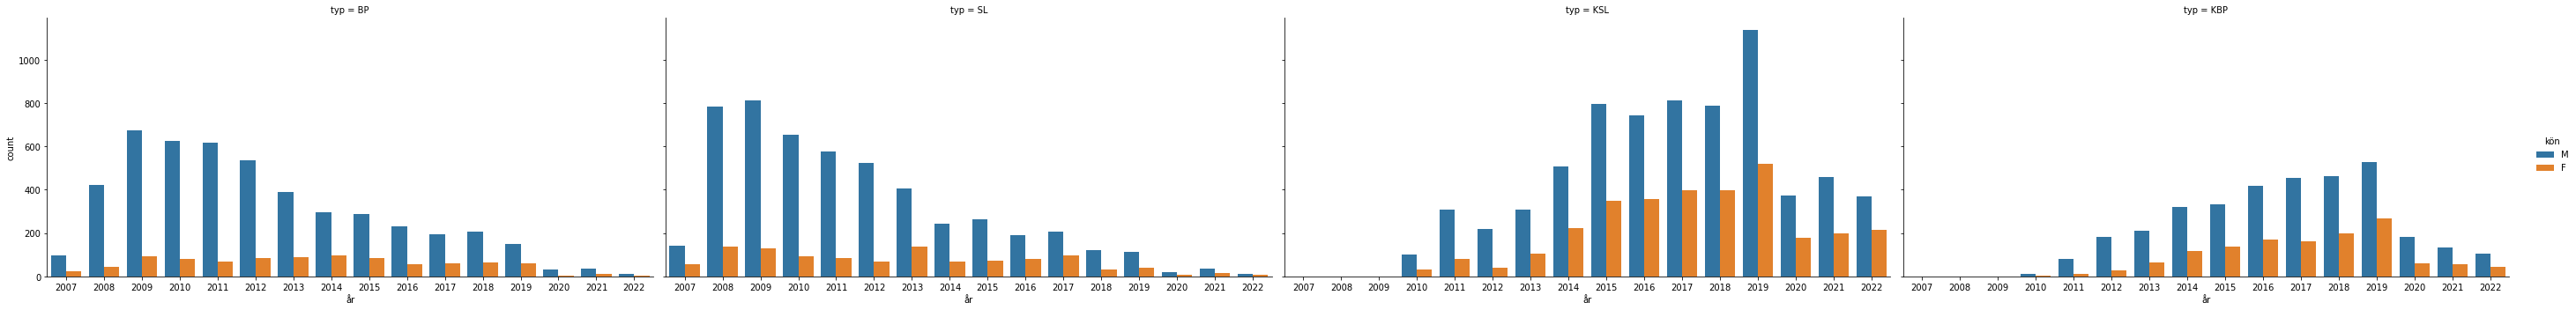

In [24]:
df['år'] = df['datum'].apply(lambda x: str(x).split('-')[0])
df.sort_values('år', ascending=True, inplace=True)
g = sns.catplot(x="år", hue='kön',  kind='count',aspect=2,
            col='typ', data=df)


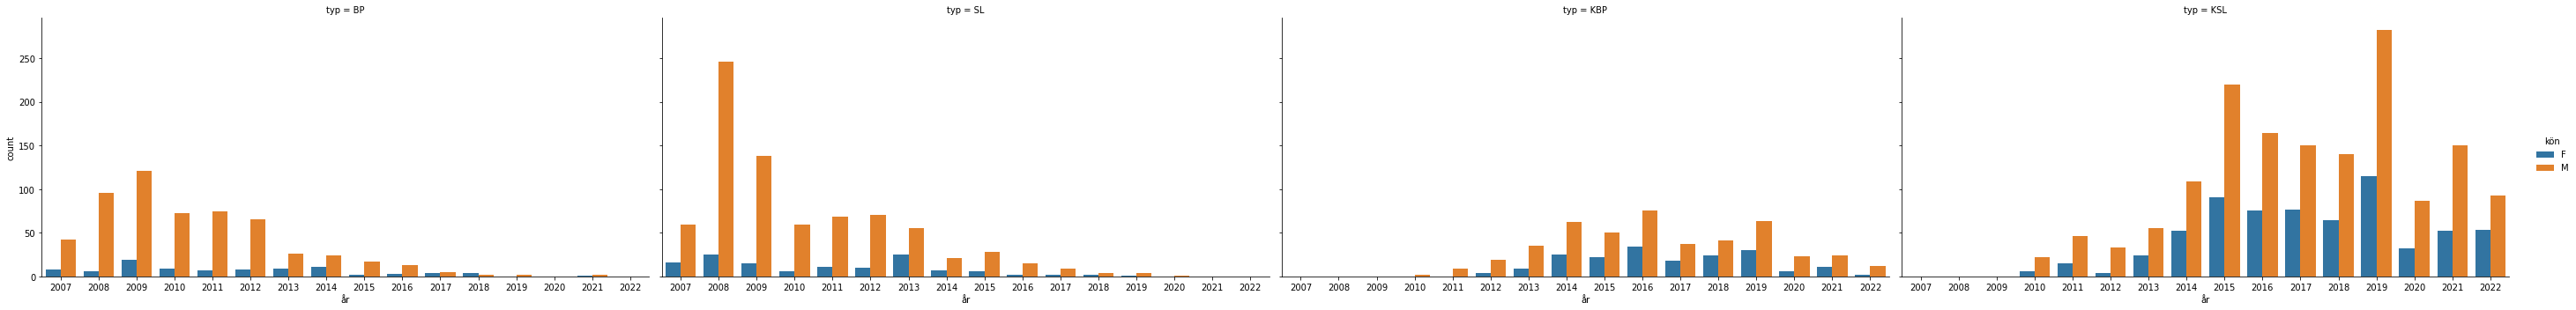

In [25]:
year_count = df.drop_duplicates(subset=['namn'])
year_count = year_count.groupby(['år','typ','kön'], as_index=False).sum()
g = sns.catplot(x="år", y='count', hue='kön',  kind='bar',aspect=2,
            col='typ', data=year_count)

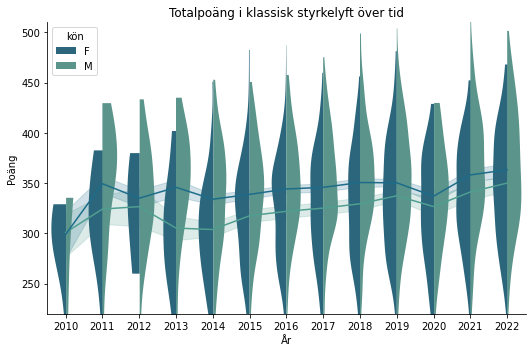

In [26]:

kl = df[df['typ'] == 'KSL']
kl = kl.sort_values(['kön','år'])
sns.relplot(hue="kön", x="år", y='poäng',  aspect=1.5, kind='line',  data = kl, legend = False, palette='crest')
kl = kl.sort_values(['kön','år'])
g=sns.violinplot(x="år", y='poäng', hue="kön", data=kl, linewidth=0, split=True, palette='crest_r', cut=-2)
#plt.legend(['M','F'])
plt.xlabel('År')
plt.ylabel('Poäng')
plt.ylim([220,510])
plt.title('Totalpoäng i klassisk styrkelyft över tid')
plt.tight_layout()
#plt.savefig('totalpoäng.jpg', bbox_inches='tight', dpi=200)


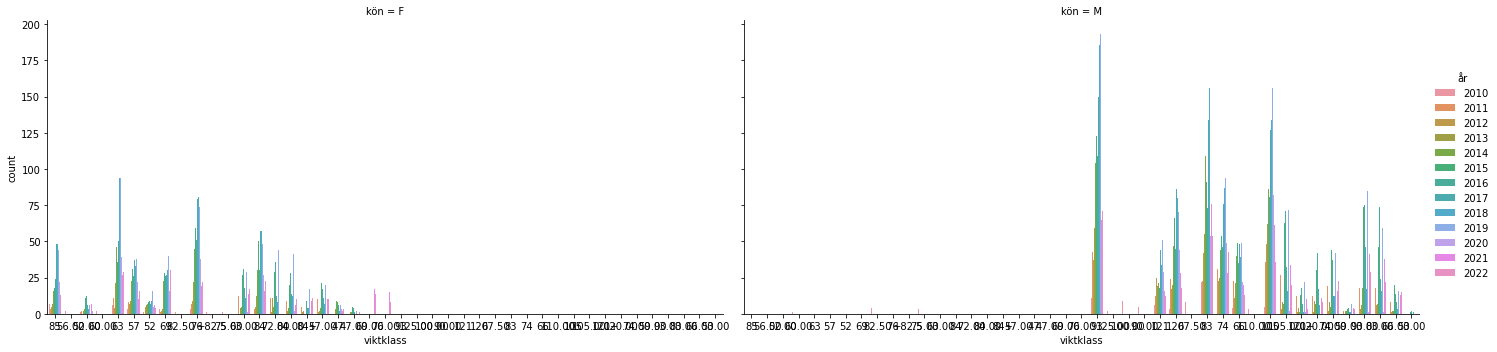

In [27]:
# fördelning av viktklasser
g = sns.catplot(x="viktklass",  aspect=2, kind='count', hue='år', data=kl, col='kön', col_wrap=2)

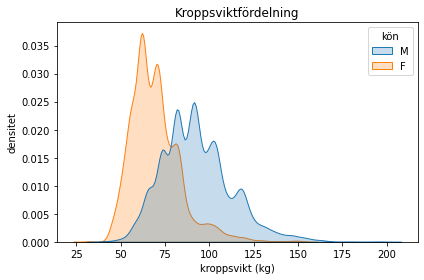

In [28]:
# viktfördelning
sns.kdeplot(x='vikt',data=df, hue='kön', fill=True, common_norm=False)
plt.xlabel('kroppsvikt (kg)')
plt.ylabel('densitet')
plt.title('Kroppsviktfördelning')
plt.tight_layout()
#plt.savefig('kroppvikt_dist.jpg', bbox_inches='tight', dpi=200)

/home/erikh/training/my-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


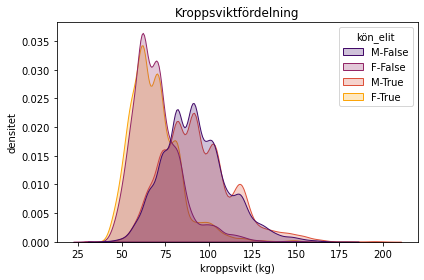

In [29]:
df['kön_elit'] = df.apply(lambda x: str(x['kön'])+ "-" + str(x['elit']), axis=1)
sns.kdeplot(x='vikt',data=df, hue='kön_elit', fill=True, common_norm=False, palette='inferno')
plt.xlabel('kroppsvikt (kg)')
plt.ylabel('densitet')
plt.title('Kroppsviktfördelning')
plt.tight_layout()

/home/erikh/training/my-venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/erikh/training/my-venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/erikh/training/my-venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/erikh/training/my-venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


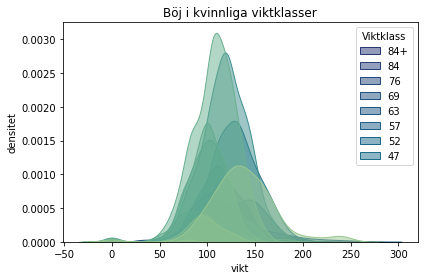

In [32]:
KSL_83 = df[df['typ'] == 'KSL']

KSL_83 = KSL_83[KSL_83['kön'] == 'F']
g = sns.kdeplot(
    data=KSL_83, x="böj", 
    hue='viktklass', fill=True, alpha=0.5,common_norm=True,palette="crest",
    levels=5, thresh=.2,
)
plt.title('Böj i kvinnliga viktklasser')
plt.xlabel('vikt')
plt.ylabel('densitet')
plt.legend(["84+",84,76,69,63,57,52,47], title='Viktklass')
plt.tight_layout()
#plt.savefig('ksl_böj_F.jpg', bbox_incehs='tight', dpi=200)

In [52]:
# optimala viktklasserna
import numpy as np
d_vikter = df[df['kön'] == 'F']['vikt'].values
n = np.random.normal(0,3,len(d_vikter))

d_vikter_n = d_vikter+n
d_vikter_n = np.sort(d_vikter_n)

antal_viktklasser = 8

vec_len = len(d_vikter_n)
weight_boundries = []
l = [i for i in list(range(antal_viktklasser+1))]
step_size = int(vec_len/antal_viktklasser)
for i in l:
    
    weight_boundries.append(d_vikter_n[i*step_size])
weight_boundries[1:-1]

[54.67393955044611,
 59.5474199805531,
 62.996718380109655,
 67.00718439221873,
 71.31048930360436,
 76.36319139076384,
 84.07941757649306]

/home/erikh/training/my-venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


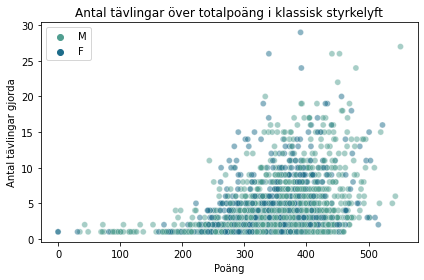

In [39]:
# antal tävlingar mot resultat
x = []
y = []
kön = []
n = []

KSL = df[df['typ'] == 'KSL']

for namn in KSL['namn'].unique():
    t = KSL[KSL['namn'] == namn]
    n.append(namn)
    medelvikt = t['vikt'].mean()
    medeltotal = t['poäng'].max()
    antal_tävlingar = len(t.index)
    k = t['kön'].values[0]
    x.append(medeltotal)
    y.append(antal_tävlingar)
    kön.append(k)

sns.scatterplot(x,y, alpha=0.5, hue=kön, palette='crest')
plt.xlabel('Poäng')
plt.ylabel('Antal tävlingar gjorda')
plt.title('Antal tävlingar över totalpoäng i klassisk styrkelyft')
plt.tight_layout()
#plt.savefig('tavlingar_vs_resultat.jpg', dpi=200, bbox_inches='tight')

/home/erikh/training/my-venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/erikh/training/my-venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


<Figure size 432x288 with 0 Axes>

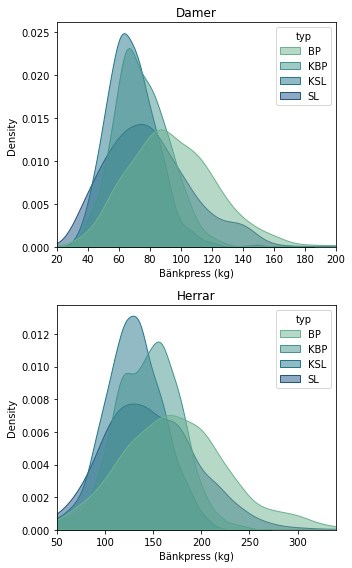

In [40]:
# hur mkt mer bänkar enbart bp än KSL

plt.clf()
KL = df[df['typ'].isin(['KSL','KBP'])]
fig, axs = plt.subplots(2, figsize=(5,8))
kön = ['F','M']
kön_verbose = ['Damer','Herrar']
i=0

for ax in axs.ravel():
    gen = df[df['kön'] == kön[i]]
    
    gen.sort_values('typ',inplace=True)
    sns.kdeplot(ax=ax,
        data=gen, x="bänk", 
        hue='typ', fill=True, alpha=0.5, common_norm=False,palette="crest",
        levels=5, thresh=.2,
    )
    ax.set_title(kön_verbose[i])
    ax.set_xlabel('Bänkpress (kg)')
    if i==0:
        ax.set_xlim([20,200])
    else:
        ax.set_xlim([50,340])
    i += 1
plt.tight_layout()
#plt.savefig('bänk.jpg', bbox_inches = 'tight', dpi=200)

        år       m kön                               namn
0   2010.0  391.73   F                    Jenny Adolfsson
1   2011.0  440.78   F                     Angelica Brage
2   2012.0  440.78   F                     Angelica Brage
3   2013.0  452.37   F                         Sofia Loft
4   2014.0  490.49   F                         Sofia Loft
5   2015.0  520.88   F                         Sofia Loft
6   2016.0  522.49   F                         Sofia Loft
7   2017.0  496.19   F                   Kristine Almroth
8   2018.0  493.84   F                       Vilma Olsson
9   2019.0  515.83   F  Isabella Eriksson von Weissenberg
10  2020.0  470.75   F                     Sandra Hansson
11  2021.0  493.76   F                        Agnes Rudin
12  2022.0  510.50   F                       Vilma Olsson
        år       m kön            namn
0   2010.0  430.38   M   Adam Luotonen
1   2011.0  477.43   M    Per Berglund
2   2012.0  476.10   M  Johannes Årsjö
3   2013.0  481.94   M    Per Be

Text(0.5, 1.0, 'Bästa jämfört med medelpoäng i klassisk styrkelyft')

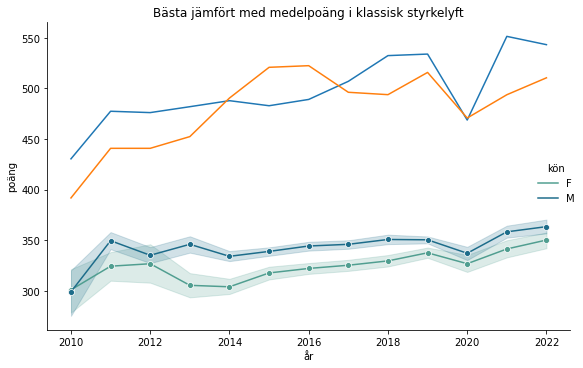

In [9]:
kl = df[df['typ'] == 'KSL']
kl = kl.sort_values(['kön','år'])
f_max = []
m_max=[]
n_f = []
n_m = []
år = kl['år'].unique()
for a in år:
    kl_s = kl[kl['år'] == a]
    f = kl_s[kl_s['kön'] == 'F']
    m = kl_s[kl_s['kön'] == 'M']
    try:
        f_m = np.max(f['poäng'].values)
        n_f.append(f[f['poäng'] == f_m]['namn'].values[0])
    except ValueError:
        f_m = 0
    try:
        m_m = np.max(m['poäng'].values)
        n_m.append(m[m['poäng'] == m_m]['namn'].values[0])
    except ValueError:
        m_m = 0
    f_max.append(f_m)
    m_max.append(m_m)

f = pd.DataFrame({'år':år,'m':f_max, 'kön':['F']*len(år), 'namn':n_f})
m = pd.DataFrame({'år':år, 'm':m_max, 'kön':['M']*len(år), 'namn':n_m})

print(f)
print(m)

sns.relplot(hue="kön", x="år", y='poäng',  aspect=1.5, kind='line', marker='o',  data = kl, palette='crest')      
sns.lineplot(data=m, y='m', x = 'år', palette='winter', legend=False,  markers='o')
sns.lineplot(data=f, y='m', x = 'år', palette='crest', legend=False,  markers='o')
plt.tight_layout()
plt.title('Bästa jämfört med medelpoäng i klassisk styrkelyft')
#plt.savefig('medel_vs_best.jpg', dpi=200,bbox_inches='tight' )


                                      tävling       datum  typ   vikt    böj  \
19983                        Div 2 herr KL SL  2018-05-21  KSL  62.45   75.0   
19982                        Div 2 herr KL SL  2018-11-12  KSL  61.95   80.0   
19981                        Div 2 herr KL BP  2019-02-18  KBP  60.55    0.0   
19980            U/J/V-SM Klassisk Styrkelyft  2019-04-27  KSL  60.65   92.5   
19979                        Div 2 herr KL BP  2019-05-06  KBP  60.74    0.0   
19978              DM Klassisk Bänkpress SSSF  2019-09-07  KBP  62.50    0.0   
27391             DM Klassisk Bänkpress SSSF   2019-09-07  KBP  62.50    NaN   
19977                        Div 2 herr KL SL  2019-09-17  KSL  62.04  107.5   
19976             DM Klassisk Styrkelyft SSSF  2019-11-16  KSL  62.40  105.0   
27205           Ungdoms SM Klassisk Bänkpress  2020-02-14  KBP  61.50    NaN   
19975           Ungdoms SM Klassisk Bänkpress  2020-02-14  KBP  61.50    0.0   
19974                  Div 2 herr SL kla

/home/erikh/training/my-venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/erikh/training/my-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/erikh/training/my-venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

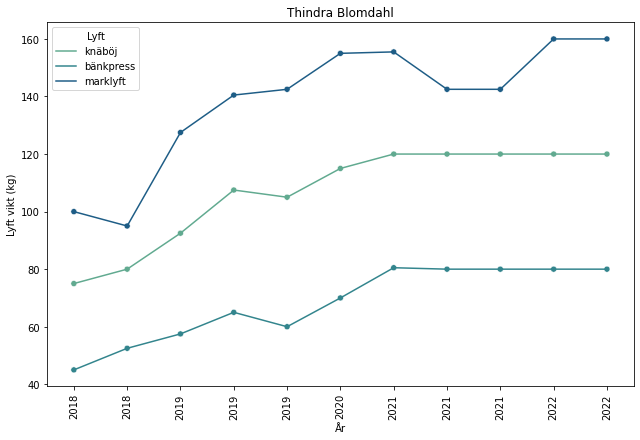

In [44]:
# Eddie Berglund
from matplotlib.dates import DateFormatter

df = pd.read_csv('complete_total.csv')
namn = "Thindra Blomdahl"
df = df[df['namn'] == namn]
df = df.sort_values('datum')
print(df)
df.fillna(0, inplace=True)
df = df[df['typ'] == 'KSL']
år = df.sort_values('år')['år'].astype(int)


s = df[['datum','böj']]
s['lyft'] = 'böj'
s['vikt'] = s['böj']
b = df[['datum','bänk']]
b['lyft'] = 'bänk'
b['vikt'] = b['bänk']
d = df[['datum','mark']]
d['lyft'] = 'mark'
d['vikt'] = d['mark']

df = pd.concat([s,b,d], ignore_index=True)
df = df[['datum','lyft','vikt']]
print(df)

fig, ax = plt.subplots(figsize = (9,6)) 
sns.lineplot(data=df[df['vikt'] > 0], x='datum',y='vikt', hue='lyft', palette='crest')
sns.scatterplot(data=df, x='datum',y='vikt', hue='lyft', palette='crest', legend=False)
ax.xaxis.set_ticks(range(len(år)))
ax.xaxis.set_ticklabels(år)

plt.xticks(rotation=90)
plt.xlabel('År')
plt.ylabel('Lyft vikt (kg)')
plt.legend(['knäböj','bänkpress','marklyft'], title='Lyft')
plt.tight_layout()
plt.title(namn)
plt.savefig(f'{namn}_lyft.jpg', dpi=200, bbox_inches='tight')


/home/erikh/training/my-venv/lib/python3.6/site-packages/seaborn/categorical.py:2805: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/home/erikh/training/my-venv/lib/python3.6/site-packages/seaborn/categorical.py:2805: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


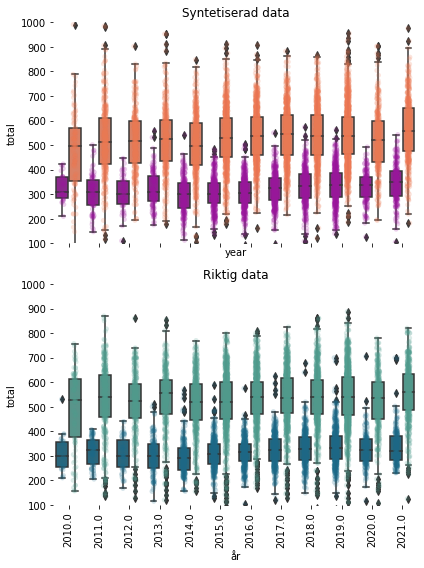

In [3]:
# Lägg till fler i normalfördelningen

df = pd.read_csv("complete_total.csv")
df['count'] = 1
df = df[df['typ'] == 'KSL']

male_mean = df[df['kön'] == 'M'].groupby('år').mean()['total'].values
female_mean = df[df['kön'] == 'F'].groupby('år').mean()['total'].values

m_overall_mean = np.mean(male_mean)
f_overall_mean = np.mean(female_mean)

male_sd = df[df['kön'] == 'M'].groupby('år')['total'].std().values
female_sd = df[df['kön'] == 'F'].groupby('år')['total'].std().values

m_overall_sd = np.mean(male_sd)
f_overall_sd = np.mean(female_sd)

competitors_per_year = df.groupby(by=['år','kön'], as_index=False).sum()

competitors_per_year = competitors_per_year.sort_values('år')
male_competitors = competitors_per_year[competitors_per_year['kön'] == 'M']
female_competitors = competitors_per_year[competitors_per_year['kön'] == 'F']
yrs = competitors_per_year['år'].unique()
nr_yrs = len(df['år'].unique())


m = pd.DataFrame()
f = pd.DataFrame()

for i in range(nr_yrs)[1:]:
    m_y = male_competitors['count'].values[i-1]
    f_y = female_competitors['count'].values[i-1]
    m_mean = male_mean[i-1]
    f_mean = female_mean[i-1]
    
    m_std = male_sd[i-1]
    f_std = female_sd[i-1]
    y = yrs[i-1]
    
    mdata = np.random.normal(m_mean, m_std, m_y)
    fdata = np.random.normal(f_mean, f_std, f_y)
    
    m_temp = pd.DataFrame({'year':[y]*m_y, 'total':mdata})
    f_temp = pd.DataFrame({'year':[y]*f_y, 'total':fdata})

    m = pd.concat([m, m_temp])
    f= pd.concat([f, f_temp])
m['kön'] = 'M'
f['kön'] = 'F'
t = pd.concat([f,m])
fig, axs = plt.subplots(2,1, figsize=(6,8), sharex=True)
sns.stripplot(ax=axs[0], x="year", y="total",palette='plasma',split=True,alpha=.2,
                hue="kön", data=t)
axs[0].set_title('Syntetiserad data')
for spine in axs[0].spines.values():
    spine.set_visible(False)
sns.stripplot(ax=axs[1], x="år", y="total",palette='crest_r',split=True,alpha=.2,
                hue="kön", data=df)
sns.boxplot(ax=axs[1], x="år", y="total",palette='crest_r',hue="kön", data=df)
sns.boxplot(ax=axs[0], x="year", y="total",palette='plasma',hue="kön", data=t )
axs[1].set_title('Riktig data')
axs[0].set_ylim([100,1000])
axs[1].set_ylim([100,1000])
axs[0].legend([],[], frameon=False)
axs[1].legend([],[], frameon=False)
for spine in axs[1].spines.values():
    spine.set_visible(False)
plt.xticks( rotation=90)
plt.tight_layout()
#plt.savefig('normal_v3.jpg', dpi=200)

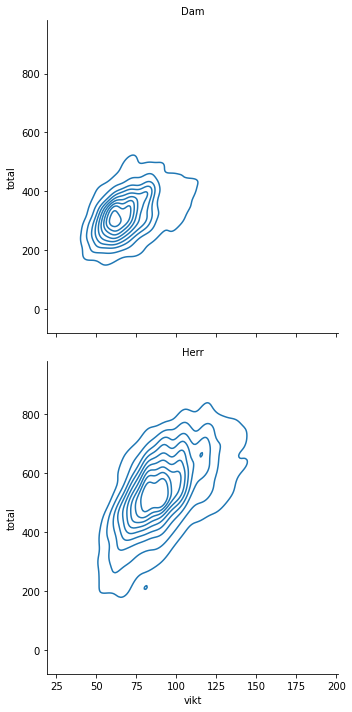

In [41]:
df = pd.read_csv("complete_total.csv")
df = df[df['typ'] == 'KSL']
df.replace('F','Dam', inplace=True)
df.replace('M','Herr', inplace=True)
g = sns.displot(data=df, x='vikt', y='total', col='kön', kind='kde', col_wrap=1, palette='crest')
g.set_titles("{col_name}")

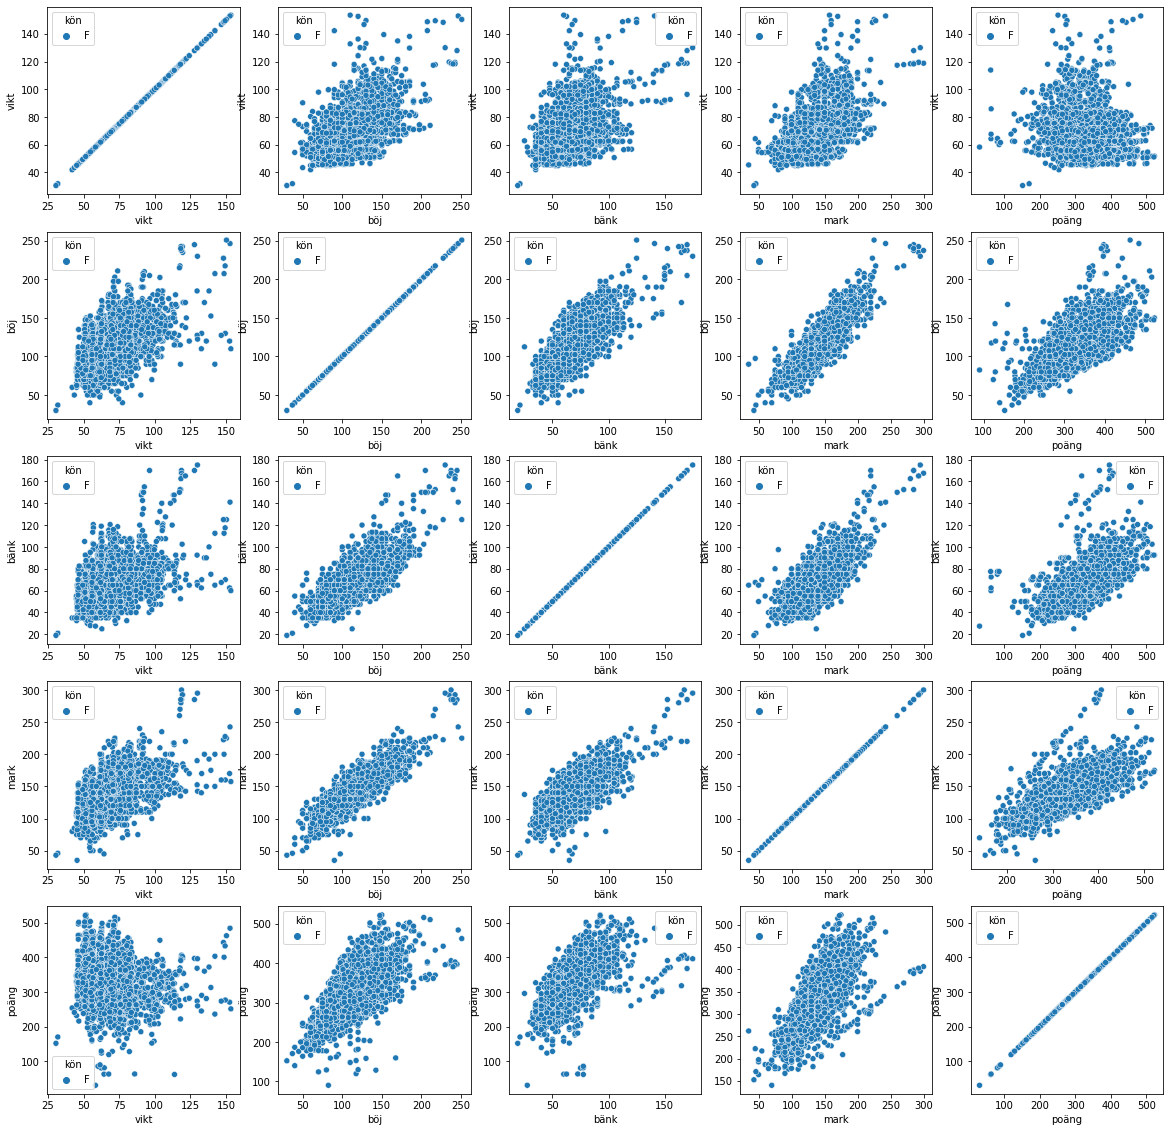

In [66]:
df = pd.read_csv("complete_total.csv")

fig, axs = plt.subplots(5,5, figsize=(20,20))
df = df[df['typ'] == 'KSL']
df = df[df['kön'] == 'F']
df.replace(0, np.nan, inplace=True)
cols = ['vikt','böj','bänk','mark','poäng']
df = df[['vikt','böj','bänk','mark','poäng','kön']]
for k in range(len(cols)):
    for i in range(len(cols)):
        ax = sns.scatterplot(x=cols[k], y=cols[i], hue='kön', data=df, ax=axs[i,k])

cormat = df.corr()


<AxesSubplot:>

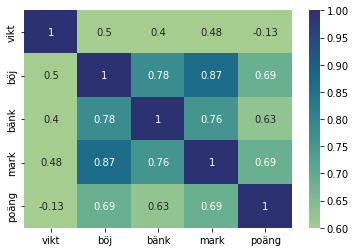

In [67]:
sns.heatmap(cormat, vmin=0.6, cmap='crest', annot=True)